##Imports

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
import glob
import shutil
import itertools
import random

from IPython.core.display import display, HTML
from matplotlib.image import imread, imsave
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, plot, iplot
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import svm, grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



##Mount google drive directory

In [3]:
from google.colab import files, drive, auth
import os

drive.mount("/content/gdrive", force_remount=False)

PATH = "/content/gdrive/My Drive/AED/"

if os.path.isfile(f"{PATH}data.zip"): #and not os.path.isdir("data/"):
    print("\nUnziping the data...")
    !unzip -q gdrive/My\ Drive/AED/data.zip
    print("Done.")
else:
    print("\nData directory already ready.")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive

Data directory already ready.


##I.  Lecture des CSV

###Lecture

In [4]:
# get in/out classification
y_intext = pd.read_csv(PATH+"Annotations2.csv", usecols=["Sequence", "Exterieur"])
y_violent = pd.read_csv(PATH+"Annotations2.csv", usecols=["Sequence", "Violent"])

df_histo = pd.read_csv(PATH + "df_histo.csv", sep="§", engine='python')
df_histo.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_histo.add_prefix('histo_')
print(df_histo.shape)

df_cuts = pd.read_csv(PATH + "df_cuts.csv", sep="§", engine='python')
df_cuts.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_cuts.add_prefix('cuts_')
print(df_cuts.shape)

df_momentum = pd.read_csv(PATH + "df_momentum.csv", sep="§", engine='python')
df_momentum.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_momentum.add_prefix('momentum_')
print(df_momentum.shape)


(308, 7681)
(308, 3)
(308, 200)


### Creation of splited annoted files (for violent and in_out)

In [5]:
# df_cuts is given just to assure function will works
# y_train, y_test, X_train, X_test = split_train_test(df_cuts, y_violent[0:308], "Violent")
# y_train.to_csv(PATH+"y_train_violent.csv", sep="§")
# y_test.to_csv(PATH+"y_test_violent.csv", sep="§")

# y_train, y_test, X_train, X_test = split_train_test(df_cuts, y_intext[0:308], "Exterieur")
# y_train.to_csv("/content/gdrive/My Drive/AED/y_train_exterieur.csv", sep="§")
# y_test.to_csv("/content/gdrive/My Drive/AED/y_test_exterieur.csv", sep="§")


NameError: ignored

##II. Clustering

###Grid search and KNN (with best number of neighbors found by GridSearch)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid("off")
    plt.axis("off")
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    
def KNN_plus_gridsearch(X, y, n_neighbors_knn, n_neighbors_grid):
    #KNN
    # split and shuffle X and y
    TEST_SIZE = np.int(np.floor(len(y)*0.2))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
    
    # train
    n_neighbors = n_neighbors_knn
    clf = KNeighborsClassifier(n_neighbors)
    
    # GRID SEARCH
    # parameters
    myList = list(range(1,n_neighbors_grid))
#     n = filter(lambda x: x % 2 != 0, myList)
    parameters = {'n_neighbors':myList}

    # learn with grid search
    model = GridSearchCV(clf, parameters)
    
    model.fit(X_train, y_train)
    
    # get the best number of neighbors found by GridSearch
    params = model.best_params_
    n_neighbors = params['n_neighbors']
    
    clf = KNeighborsClassifier(n_neighbors)
    
    clf.fit(X_train, y_train.ravel())

    # predict
    y_pred = clf.predict(X_test)

    # transform into dataframe
    y_pred = pd.DataFrame(y_pred)
    y_pred.index = y_test.index
    
    df = pd.concat([y_pred, y_test], axis=1)
    df.columns = ['pred', 'test']

    # confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, classes=['violent','non violent'], title='Matrice de confusion violence')

    #accuracy
    acc = sum(1 for i in df.index if df['test'][i] == df['pred'][i]) / df.shape[0]
    
    return df, confusion, acc, params

###PCA

In [0]:
pca = PCA(n_components=2)
cuts_pca = pca.fit_transform(df_cuts.drop("Sequence", axis=1))
histo_pca = pca.fit_transform(df_histo.drop("Sequence", axis=1))
momentum_pca = pca.fit_transform(df_momentum.drop("Sequence", axis=1))


###Prédictions

Paramètres modifiable:
- seuil de détection des cuts (seuil)
- nombre de plus proches voisins (voisins)

Résultat :
- accuracy (acc)

VIOLENT/NON-VIOLENT

confusion cuts


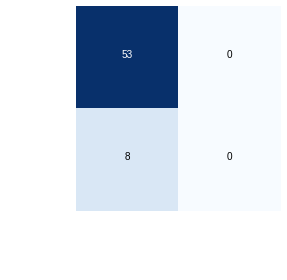

accuracy: 86.885

confusion_histo


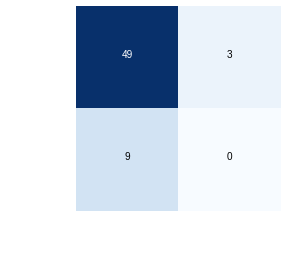

accuracy: 80.328

confusion momentum


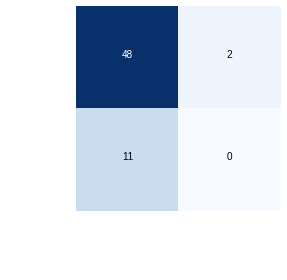

accuracy: 78.689


In [11]:
# print("INTERIEUR/EXTERIEUR")
# #notre meilleur préd est de 62% < 64% LOL
# print ("\nconfusion cuts")
# df_1, confusion_1, acc_1, params_1 = KNN_plus_gridsearch(cuts_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_1*100:.3f} %")

# print("\nconfusion_histo")
# df_2, confusion_2, acc_2, params_2 = KNN_plus_gridsearch(histo_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_2*100:.3f} %")

# print("\nconfusion momentum")
# df_3, confusion_3, acc_3, params_3 = KNN_plus_gridsearch(momentum_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_3*100:.3f} %")


print("VIOLENT/NON-VIOLENT")
print ("\nconfusion cuts")
df_1, confusion_1, acc_1, params_1 = KNN_plus_gridsearch(cuts_pca, y_violent.Violent[0:308], 7, 50)
print(f"accuracy: {acc_1*100:.3f}")

print("\nconfusion_histo")
df_2, confusion_2, acc_2, params_2 = KNN_plus_gridsearch(histo_pca, y_violent.Violent[0:308], 7, 50)
print(f"accuracy: {acc_2*100:.3f}")

print("\nconfusion momentum")
df_3, confusion_3, acc_3, params_3 = KNN_plus_gridsearch(momentum_pca, y_violent.Violent[0:308], 7, 50)
print(f"accuracy: {acc_3*100:.3f}")
